In [1]:
%load_ext autoreload
%autoreload 2

# standard stuff
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import json
import pickle 
import time
from tqdm import tqdm
import datetime as dt
from collections import Counter


# text processing
import re
with open('stopwords-de.json', 'r') as file:
    stopwords_de = json.load(file)
import spacy
nlp = spacy.load('de')


# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# SK-LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Gensim LDA
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing, party_remover

In [80]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/lda_data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,10)]


if read_in:
    parties = parties
    dates = dates
    aug_data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        aug_data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(aug_data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        aug_data = pickle.load(fid)
        print('data loaded')


  0%|          | 0/8 [00:00<?, ?it/s]

Loading: ['08-02', '08-03', '08-04', '08-05', '08-06', '08-07', '08-08', '08-09']



100%|██████████| 8/8 [01:06<00:00,  8.26s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

AfD loaded



100%|██████████| 8/8 [00:20<00:00,  2.55s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

SPD loaded



100%|██████████| 8/8 [00:17<00:00,  2.21s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

CDU loaded



100%|██████████| 8/8 [00:15<00:00,  1.90s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

CSU loaded



100%|██████████| 8/8 [00:47<00:00,  5.89s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

FDP loaded



100%|██████████| 8/8 [00:13<00:00,  1.72s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

LINKE loaded



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

Gruene loaded



100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


Grüne loaded
Done


In [3]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data_lda.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(aug_data)
    df_processing(all_data)
    all_data = all_data.drop_duplicates('clean_text')
    all_data['user_id'] = all_data.loc[:, 'user'].map(lambda x: x['id_str'])
    all_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# LDA using the scikit-learn package

In [4]:
cv = CountVectorizer(stop_words=stopwords_de,
                    max_df=.1,
                    max_features=5000)

X = cv.fit_transform(all_data.loc[:, 'clean_text'])

In [5]:
lda = LatentDirichletAllocation(n_components=5,
                               random_state=123,
                               learning_method='batch')

X_topics = lda.fit_transform(X)

In [6]:
lda.components_.shape

(5, 5000)

In [7]:
n_top_words = 5
feature_names = cv.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print('Topic {}'.format(topic_idx + 1))
    print(' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words -1:-1]]))

Topic 1
aufstehen partei sammlungsbewegung linken wagenknecht
Topic 2
ueber nazis partei waehler rechts
Topic 3
cdu fdp csu wehrpflicht merkel
Topic 4
gruene politik einfach leute muessen
Topic 5
gruene deutschland csu seehofer bayern


In [47]:
def daily_topifier(df, cv_features, n_topics, n_top_words):
    dates = ['2018-08-{:02d}'.format(i) for i in range(2,10)]
    topics = {}
    
    for date in dates:
        cv = CountVectorizer(stop_words=stopwords_de, max_df=.1, max_features=cv_features)
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=123, learning_method='batch')
        X = cv.fit_transform(df.loc['{}'.format(date), 'clean_text'])
        X_topics = lda.fit_transform(X)
        feature_names = cv.get_feature_names()
        for topic_idx, topic in enumerate(lda.components_):
            topics['{}, {}'.format(date, topic_idx + 1)] = [' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words -1:-1]])]
            
    return topics

In [51]:
topics = daily_topifier(all_data, cv_features=5000, n_topics=5, n_top_words=5)

topics
# interesting: afd is very common but does not appear to be a topic

# LDA using gensim 

- take only words with certain tags from the cleaned text (tags in this context referring to word tags = nouns, adjectives, ect.)
- prepare a common dictionary
- prepare common corpus with vectorized (bow) words
- run lda on corpus and evaluate coherence using the coherence model and visualizations

In [57]:
text = all_data.loc[:, 'clean_text']

document = []

for row in text.iteritems():
    index, data = row
    document.append(data)

corpus = [[word for word in str(doc).lower().split() if word not in stopwords_de and len(word) > 2] for doc in document]
common_dictionary = corpora.Dictionary(corpus, prune_at=10000)
common_corpus = [common_dictionary.doc2bow(t) for t in corpus]

In [58]:
text

created_at
2018-08-02 00:00:14     Fuer  Sami  A  macht  man  Rundfluege   gute ...
2018-08-02 00:00:32      NoAFD  schreiben  aber  keine  Argumente  li...
2018-08-02 00:00:32           Ich  kenne  nur  die  REPs  Baden  Wuer...
2018-08-02 00:01:33        Drittens  in  kauf  nehmen  ist  ungleich ...
2018-08-02 00:02:08    Damit  wir  die  Werte   AfD  besser  verstehe...
2018-08-02 00:02:17       Es  ist  uebrigens  so   als  wuerde  ich  ...
2018-08-02 00:02:28    Brisante  Amri  Enthuellungen  finden  Eingang...
2018-08-02 00:03:07          Grausamer  Mord  an    kleinen  Maedchen...
2018-08-02 00:03:11       Die  Genossen  der   SPD  lehnen    Aufnahm...
2018-08-02 00:03:28     Heisst  das  du  hast  die  AFD  gewaehlt    ...
2018-08-02 00:03:56    Die  Masken  fallen    Wie  die    spricht  Wi...
2018-08-02 00:04:18        Viertens  gibt  es  keine  Anzeichen  dafu...
2018-08-02 00:04:31       Brisante  Amri  Enthuellungen  finden  Eing...
2018-08-02 00:06:31        Ihr  Heimatze

In [59]:
path_corpus = '../Data/lda_corpus.pkl'
path_dic = '../Data/lda_dic.pkl'
with open(path_corpus, 'wb') as fid:
    pickle.dump(common_corpus, fid)

with open(path_dic, 'wb') as fid:
    pickle.dump(common_dictionary, fid)

/home/franzi/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



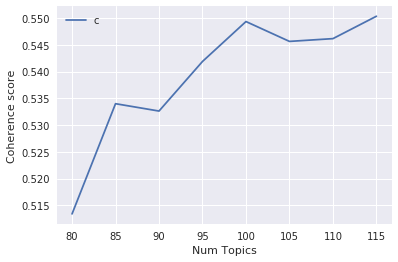

In [66]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence for various number of topics

    Parameters:
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Plots coherence score over number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=0.1, )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

compute_coherence_values(common_dictionary, common_corpus, corpus, limit=120, start=80, step=5)

Following from coherence score curve
- choose 105 topics 

Following from LDA visualization
- comparing topic-bubbles of different numbers of topics: chosing 105 topics results in nicely distributed, hardly overlapping clusters

In [84]:
# divide by zero error: unsolved, not understood problem that apparently can be ignored
lda = LdaModel(common_corpus, num_topics=50, id2word=common_dictionary, alpha=2, random_state=123)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

# Compute Coherence Score using u-mass
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

ldavis_prepared = pyLDAvis.gensim.prepare(lda, common_corpus, common_dictionary)

pyLDAvis.display(ldavis_prepared)

Coherence Score:  0.62525866511
Coherence Score:  -15.7698961624


https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

- A topic in LDA is a multinomial distribution over the (typically thousands of) terms in the vocabulary of the corpus. 

In [21]:
def daily_lda(df, stoplist, n_topics, n_words, startdate, stopdate):
    dates = ['2018-08-{:02d}'.format(i) for i in range(startdate, stopdate)]
    topics = {}
    
    for date in dates:
        text = all_data.loc['{}'.format(date), 'clean_text']

        document = []

        for row in text.iteritems():
            index, data = row
            document.append(data)

        corpus = [[word for word in str(doc).lower().split() if word not in stoplist and len(word) > 2] for doc in document]
        common_dictionary = corpora.Dictionary(corpus)
        common_corpus = [common_dictionary.doc2bow(t) for t in corpus]
        lda = LdaModel(common_corpus, num_topics=n_topics, id2word=common_dictionary, alpha=0.001, random_state=123)
        topic = lda.show_topics(num_topics=n_topics, num_words=n_words,formatted=False)
        topics['{}'.format(date)] = [(tp[0], [wd[0] for wd in tp[1]]) for tp in topic]
        
        coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print('Coherence Score {}:'.format(date), coherence_lda)
    return topics

In [27]:
daily_topics = daily_lda(all_data, stoplist=stopwords_de, n_topics=17, n_words=5, startdate=2, stopdate=10)

Coherence Score:  0.572570466436
Coherence Score:  0.611707517756
Coherence Score:  0.570369261323
Coherence Score:  0.517245772999
Coherence Score:  0.606693862622
Coherence Score:  0.595221152767
Coherence Score:  0.569435248234
Coherence Score:  0.5792940615


In [28]:
daily_topics

{'2018-08-02': [(0, ['sommer', 'letzten', 'bringen', 'millionen', 'paar']),
  (1, ['eher', 'deutschland', 'seehofer', 'regierung', 'kirche']),
  (2, ['kritik', 'seehofer', 'ard', 'pflege', 'problem']),
  (3, ['nato', 'pro', 'journalisten', 'passt', 'logik']),
  (4, ['bayern', 'bild', 'hitze', 'themen', 'bitte']),
  (5, ['berlin', 'retten', 'weiss', 'staedte', 'religion']),
  (6, ['klimawandel', 'grad', 'ideologie', 'werte', 'blume']),
  (7, ['mitte', 'energiewende', 'klimawandel', 'europa', 'politik']),
  (8, ['wald', 'hitzewelle', 'naechsten', 'deutschland', 'hamburg']),
  (9, ['antideutsche', 'rechts', 'partei', 'arbeit', 'seite']),
  (10, ['sagen', 'klimaschutz', 'baden', 'fordert', 'deutschen']),
  (11, ['bringt', 'libyen', 'dielinke', 'partei', 'taeglich']),
  (12, ['soeder', 'horst', 'union', 'seehofer', 'letzte']),
  (13, ['groko', 'bauern', 'landwirtschaft', 'duerre', 'sammlungsbewegung']),
  (14, ['fordern', 'deutschland', 'mitte', 'sowas', 'autos']),
  (15, ['land', 'merkel',

In [29]:
df_topics = pd.DataFrame(daily_topics)

In [30]:
df_topics = df_topics.transpose()

In [31]:
df_topics

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
2018-08-02,"(0, [sommer, letzten, bringen, millionen, paar])","(1, [eher, deutschland, seehofer, regierung, k...","(2, [kritik, seehofer, ard, pflege, problem])","(3, [nato, pro, journalisten, passt, logik])","(4, [bayern, bild, hitze, themen, bitte])","(5, [berlin, retten, weiss, staedte, religion])","(6, [klimawandel, grad, ideologie, werte, blume])","(7, [mitte, energiewende, klimawandel, europa,...","(8, [wald, hitzewelle, naechsten, deutschland,...","(9, [antideutsche, rechts, partei, arbeit, sei...","(10, [sagen, klimaschutz, baden, fordert, deut...","(11, [bringt, libyen, dielinke, partei, taegli...","(12, [soeder, horst, union, seehofer, letzte])","(13, [groko, bauern, landwirtschaft, duerre, s...","(14, [fordern, deutschland, mitte, sowas, autos])","(15, [land, merkel, politik, waehlen, stadt])","(16, [prozent, liebe, voll, august, ausgerechn..."
2018-08-03,"(0, [sammlungsbewegung, aufstehen, wagenknecht...","(1, [wetter, passt, einfach, schoen, bauen])","(2, [lassen, artikel, merkel, ltwby, schuld])","(3, [horst, klimawandel, rassismus, stadt, deu...","(4, [kinder, gentechnik, seehofer, angst, span...","(5, [bewegung, milliarden, aldi, gibts, schule])","(6, [klima, duerre, retten, glauben, kachelmann])","(7, [klimafluechtlinge, bayern, nachwuchs, thu...","(8, [herr, oesterreich, brauchen, klimawandel,...","(9, [frau, voellig, fordern, partei, har])","(10, [extrem, wahrscheinlich, luft, seehofer, ...","(11, [afrika, hitze, rot, schwarz, nahles])","(12, [selber, seehofer, bleibt, twittern, rote])","(13, [klingt, erde, europa, bitte, antwort])","(14, [jugend, staatsbuergerschaft, europaeisch...","(15, [typisch, staedte, news, haelt, gruenes])","(16, [asyl, dumm, gerne, maenner, fordert])"
2018-08-04,"(0, [klimawandel, jugend, fordern, milliarden,...","(1, [problem, klimafluechtlinge, milliarden, a...","(2, [sammlungsbewegung, anpassung, umfrage, on...","(3, [hitze, sieht, raus, fuers, rot])","(4, [augen, genau, erklaeren, deutsche, versuc...","(5, [heimat, halt, bayern, saetzen, dumm])","(6, [klimakrise, merkel, deutschland, groko, g...","(7, [fluchtgrund, fachkraefte, deutschland, le...","(8, [wehrpflicht, maenner, frauen, dienstpflic...","(9, [eckardt, goering, fluchtgrund, welt, jahr...","(10, [seehofer, fordern, politiker, nato, helf...","(11, [kge, sahra, idee, news, deutschland])","(12, [brauchen, aufstehen, dummheit, wagenknec...","(13, [fonds, fraktionschefin, fluchtgrund, koe...","(14, [sieht, nix, themen, gesicht, obwohl])","(15, [aufstehen, wagenknecht, deutschland, mon...","(16, [sieht, klima, langsam, fragt, nimmt])"
2018-08-05,"(0, [merkel, rot, seehofer, frau, bringt])","(1, [lindner, frauen, kritisiert, waehlt, mio])","(2, [goering, eckardt, fordern, liebe, mensche...","(3, [bundeswehr, wehrpflicht, hitze, klar, gew...","(4, [debatte, nochmal, idee, hoffentlich, scho...","(5, [weiss, sammlungsbewegung, aufstehen, deut...","(6, [fluchtgrund, klimakrise, leute, welt, par...","(7, [klimawandel, politik, fragen, innenminist...","(8, [rot, wehrpflicht, chef, letzten, soziale])","(9, [sieht, geld, werte, gemeinschaft, politik])","(10, [seehofer, bayern, landtagswahl, umfragen...","(11, [asyl, seehofer, erklaeren, horst, wochen])","(12, [bewegung, aufstehen, regierung, leben, n...","(13, [sommerinterview, jugend, zukunft, unters...","(14, [dienstpflicht, problem, deutschland, fre...","(15, [baerbock, stimme, leben, gruener, seite])","(16, [deutschland, metwo, sahra, zivildienst, ..."
2018-08-06,"(0, [meinung, baeume, bewegung, setzt, zufaell...","(1, [rot, spiegel, sehen, liebe, bitte])","(2, [idee, seehofer, hohe, wagenknecht, sahra])","(3, [propaganda, erklaeren, bielefeld, seite, ...","(4, [zitat, august, tweet, sieht, fast])","(5, [kretschmann, technologie, deutschlands, m...","(6, [sammlungsbewegung, aufstehen, yeah, goeri...","(7, [klima, asyl, thema, sicherheit, fordert])","(8, [luegen, kinder, fordern, nato, innen])","(9, [ltwby, wetter, debatte, schieben, forde

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [ ]:
user_text = df_part.loc[:, ['user_id', 'clean_text']]
user_text.reset_index()
user_text = pd.DataFrame(user_text.groupby(user_text['user_id'])['clean_text'].apply(lambda x: '. '.join(x.astype(str))))

user_tags = df_part.loc[:, ['user_id', 'topics']]
user_tags.reset_index()
user_tags = pd.DataFrame(user_tags.groupby(user_tags['user_id'])['tags'].apply(lambda x: '. '.join(x.astype(str))))

user_tweetcount = pd.DataFrame(df_part.loc[:, 'user_id'].groupby(df_part['user_id']).count())

user_dflist = [user_text, user_tags, user_tweetcount]

In [35]:
test_df = pd.read_pickle('../Data/all_data_lda.pickle')

In [36]:
test_df.head()

,created_at,full_text,tags,mentions,clean_text,parties,stemmed,user_id
created_at,,,,,,,,
2018-08-02 00:00:14,2018-08-02 00:00:14,@BILD Für Sami A macht man Rundflüge. gute Mig...,"[CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD...",[BILD],Fuer Sami A macht man Rundfluege gute ...,"[AfD, SPD, CSU, FDP]",fuer sami a macht man rundflueg gut m...,884513792062881794
2018-08-02 00:00:32,2018-08-02 00:00:32,@bembelpix @AfD_Hessen NoAFD schreiben aber ke...,[],"[bembelpix, AfD_Hessen]",NoAFD schreiben aber keine Argumente li...,[AfD],noafd schreib aber kein argument lief ...,702527680722419712
2018-08-02 00:00:32,2018-08-02 00:00:32,RT @Walnusskipferl: @AssetsKater72 @dr_ecksack...,[],"[Walnusskipferl, AssetsKater72, dr_ecksack_, i...",Ich kenne nur die REPs Baden Wuer...,[],ich kenn nur die reps bad wuertte...,3438043463
2018-08-02 00:01:33,2018-08-02 00:01:33,@NeotherealNeo @vonduessel @AfD @AndreasKalbit...,[],"[NeotherealNeo, vonduessel, AfD, AndreasKalbitz]",Drittens in kauf nehmen ist ungleich ...,[AfD],dritt in kauf nehm ist ungleich woll...,846319908254367744
2018-08-02 00:02:08,2018-08-02 00:02:08,Damit wir die Werte #AfD besser verstehen. #Af...,"[AfD, AfDwirkt]",[],Damit wir die Werte AfD besser verstehe...,[AfD],damit wir die wert afd bess versteh ...,165708897
